# PROYECTO FINAL - PREDICCIÓN DE TIPO DE BIEN DE PROPIEDAD HORIZONTAL
**Maestria en Inteligencia Artificial - Electiva 2** \
*Estudiante:* Germán Andrés Rojas Mahecha

## Caso de Negocio


**Contexto:** Uno de los requisitos de un proyecto inmobiliario para su escrituración y entrega a los propietarios finales es contar con una licencia de propiedad horizontal (PH). Este proceso consiste en el desarrollo de una serie de documentos técnicos donde se describe un proyecto arquitectonico bajo los criterios de la Ley 675 de 2001 que rige en Colombia la Propiedad Horizontal, y estos se radican ante Curaduría o Secretaría de Planeación según el municipio donde se ubique el proyecto. Estos documentos técnicos de PH son desarrollados por arquitectos especializados en el tema. \
**Problema específico a resolver**: La importancia de los documentos técnicos radica en establecer de manera precisa si cada uno de los espacios o áreas que comprenden el proyecto arquitectónico son Bienes Privados o Bienes Comunes. Este proceso de asignación se realiza de forma manual por parte de los arquitectos. El objetivo de este modelo de ML de clasificación es que basado en una serie de caracteristicas geometricas de cada uno de los bienes realizar la predicción de si es un Bien Privado o un Bien Común, inicialmente como un apoyo en el proceso de control de calidad al realizar los documetnos técnicos de PH, y posteriormente para determinar de manera automatica la clasificación de cada Bien de un proyecto ante el input de un modelo tridimensional espacial no etiquetado.

## Contenido del Dataset

*El Dataset describe las caracteristicas geometricas mas importantes que describen a un elemento espacial de PH. A continuación se describen las caracteristicas:* \
**Area**: Superficie que cubre el elemento espacial expresada en m2. \
**Perimetro**: Suma de la longitud de todos sus lados expresada en m. \
**Cantidad_Vertices**: Número de vertices que conforman el poligono. A mayor cantidad de vertices mas irregular es el poligono. \
**Contornos_Internos**: Numero de "huecos" al interior del elemento espacial, indicando áreas que no son parte de su superficie. \
**Nivel**: Altura en metros sobre el nivel 0 del terreno. Una altura negativa indica que el elemento se encuentra en un sótano, una altura entre 0 y 1.5 metros indica que se encuentra en el nivel de acceso del proyecto, y una altura superior a 1.5 metros indica que se encuentra en el Piso 2 o superior (requiere escalera o ascensor para acceder) \
**RMC_Largo**: Longitud en m (Lado en el eje X del plano orientado en la misma dirección del elemento) del Rectangulo Minimo que contiene al elemento espacial. \
**RMC_Alto**: Alto en m (Lado en el eje Y del plano orientado en la misma dirección del elemento) del Rectangulo Minimo que contiene al elemento espacial. \
**RMC_Ratio**: Relación entre el largo y el alto de del Rectangulo Minimo Contenedor. Expresado como un numero real \
**Tipo_Area_PH**: Categoría de Bien de PH. Caracteristica a predecir. (Privada/Común)


## Exploración

In [81]:
# Cargar las librerias requeridas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [26]:
# Cargar el dataset
df = pd.read_csv("s3://electiva2-proyecto-final/Data/spatial_elements_ph.csv", usecols=(lambda x: x != 'Objeto_rvt'))

In [27]:
df

,Area,perimetro,Cantidad_Vertices,Contornos_Interiores,Nivel,RMC_Largo,RMC_Alto,RMC_Ratio,Tipo_Area_PH
0,43.152,27.22,9,0,1.500,8.01,5.61,1.43,Privada
1,41.652,26.62,6,0,1.500,7.80,5.52,1.41,Privada
2,42.204,26.84,7,0,1.500,7.90,5.52,1.43,Privada
3,42.152,26.84,8,0,1.500,7.90,5.52,1.43,Privada
4,43.152,27.20,8,0,1.500,8.00,5.62,1.42,Privada
...,...,...,...,...,...,...,...,...,...
7987,32.584,122.46,30,0,29.880,6.79,5.99,1.13,Privada
7988,31.781,119.11,24,0,29.880,7.10,5.84,1.22,Privada
7989,27.561,85.07,22,0,50.531,6.50,5.66,1.15,Privada
7990,27.629,78.31,18,0,50.531,6.56,5.56,1.18,Privada


In [28]:
# Convertir la columna Tipo_Area_PH (Target) a una clasificación binaria
df['Tipo_Area_PH'] = df['Tipo_Area_PH'].apply(lambda x: 0 if x == "Privada" else 1)
df.head()

,Area,perimetro,Cantidad_Vertices,Contornos_Interiores,Nivel,RMC_Largo,RMC_Alto,RMC_Ratio,Tipo_Area_PH
0,43.152,27.22,9,0,1.5,8.01,5.61,1.43,0
1,41.652,26.62,6,0,1.5,7.80,5.52,1.41,0
2,42.204,26.84,7,0,1.5,7.90,5.52,1.43,0
3,42.152,26.84,8,0,1.5,7.90,5.52,1.43,0
4,43.152,27.20,8,0,1.5,8.00,5.62,1.42,0


In [29]:
df['Tipo_Area_PH'].value_counts()

0    5541
1    2451
Name: Tipo_Area_PH, dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7992 entries, 0 to 7991
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Area                  7992 non-null   float64
 1   perimetro             7992 non-null   float64
 2   Cantidad_Vertices     7992 non-null   int64  
 3   Contornos_Interiores  7992 non-null   int64  
 4   Nivel                 7992 non-null   float64
 5   RMC_Largo             7992 non-null   float64
 6   RMC_Alto              7992 non-null   float64
 7   RMC_Ratio             7992 non-null   float64
 8   Tipo_Area_PH          7992 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 562.1 KB


In [36]:
df.describe()

,Area,perimetro,Cantidad_Vertices,Contornos_Interiores,Nivel,RMC_Largo,RMC_Alto,RMC_Ratio,Tipo_Area_PH
count,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000
mean,234.178494,56.431368,17.563188,0.258509,10.773884,11.459347,6.991767,2.753493,0.306682
std,1766.538488,83.237479,17.078412,3.351511,15.171983,23.275347,14.656829,7.065682,0.461145
min,0.110000,1.300000,3.000000,0.000000,-7.000000,0.360000,0.110000,1.000000,0.000000
25%,12.500000,20.275000,8.000000,0.000000,0.000000,5.850000,2.580000,1.170000,0.000000
50%,35.104000,30.260000,14.000000,0.000000,2.450000,7.710000,6.020000,1.440000,0.000000
75%,46.919000,41.390000,21.000000,0.000000,18.100000,9.350000,6.440000,1.980000,1.000000
max,59436.953000,997.710000,309.000000,127.000000,66.301000,337.580000,242.380000,241.670000,1.000000


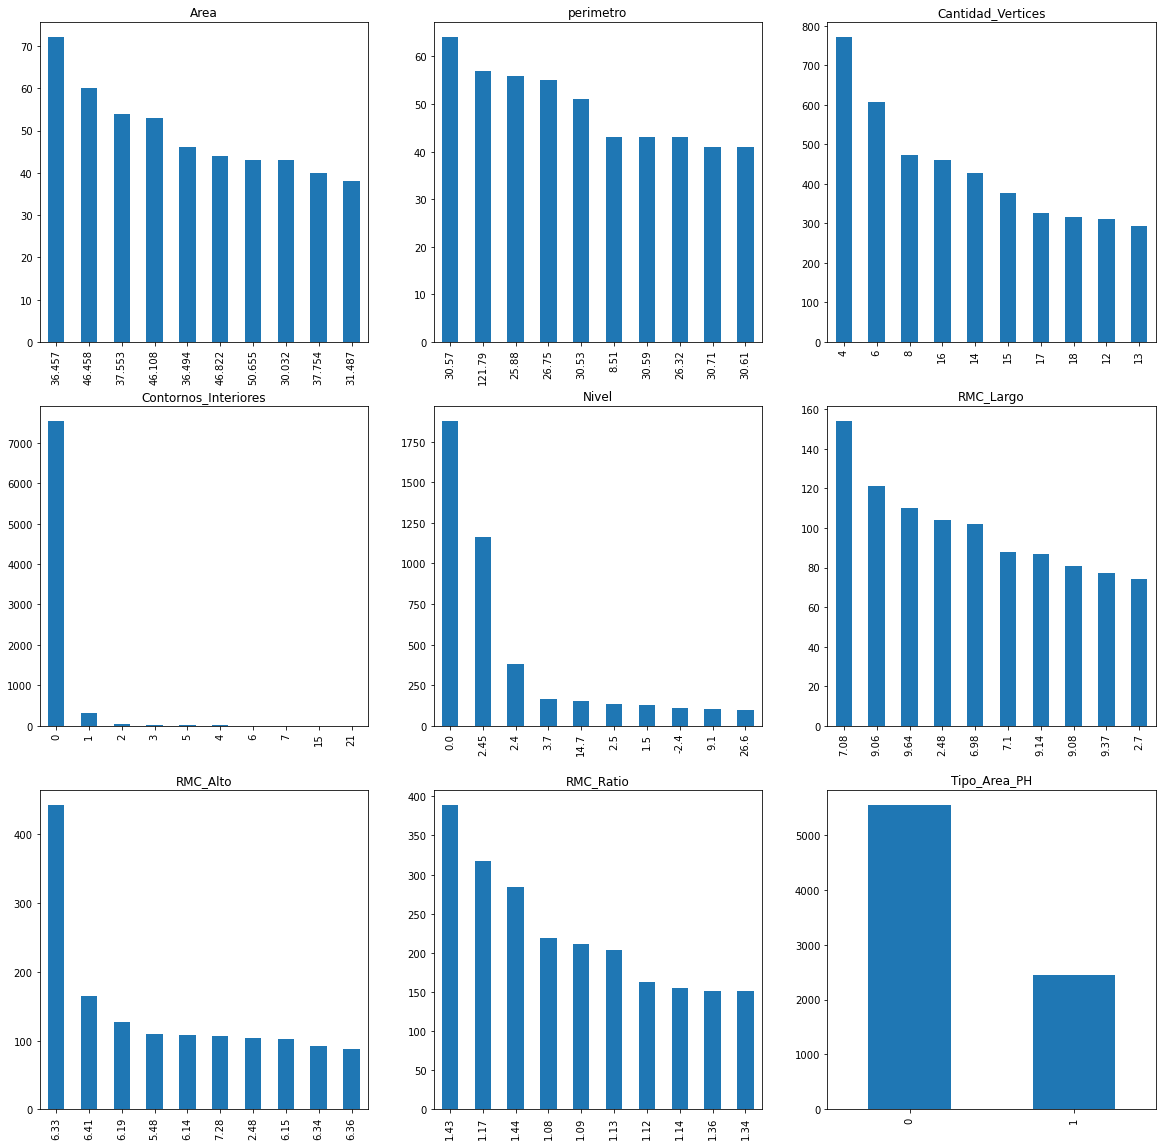

In [96]:
# Valores mas frecuentes
fig, ax = plt.subplots(3, 3)
for ind, feature in enumerate(df.columns):
    df[feature].value_counts().nlargest(10).plot(ax=ax[math.floor(ind/3), ind%3],kind='bar', figsize=(20, 20), title=feature)

<AxesSubplot:xlabel='Area', ylabel='count'>

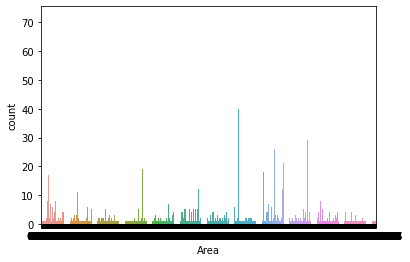

In [64]:
sns.countplot(x="Area",data=df)

In [59]:
df["Contornos_Interiores"].value_counts().nlargest(5)

0    7532
1     319
2      49
3      22
5       8
Name: Contornos_Interiores, dtype: int64

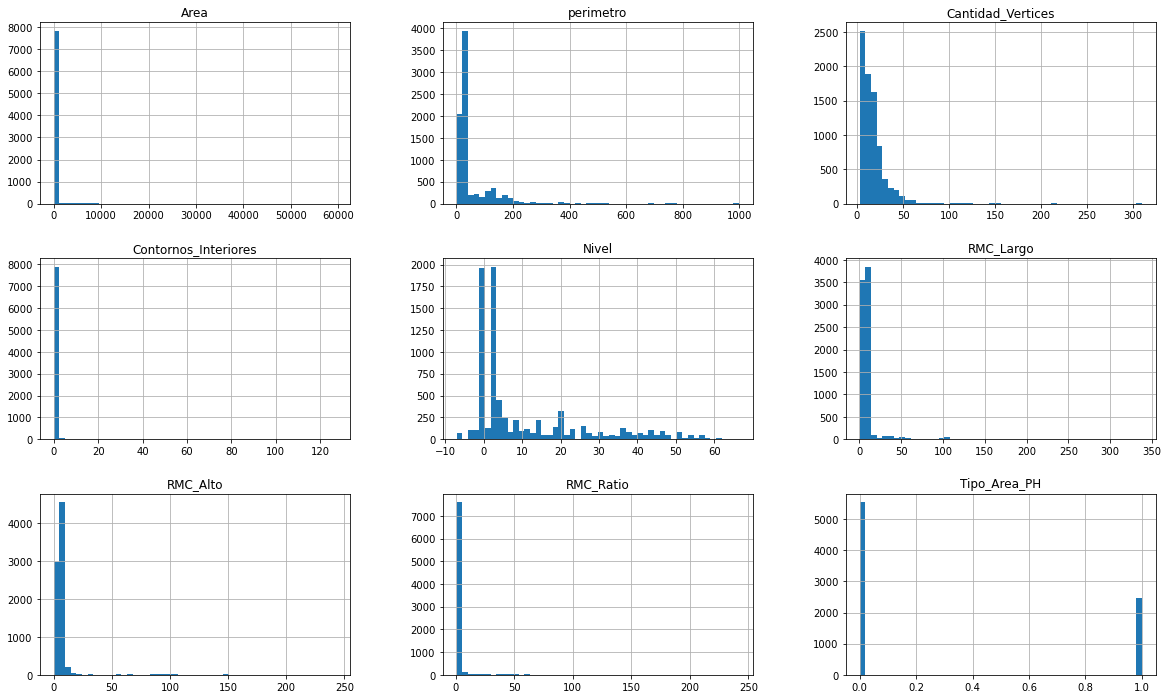

In [97]:
df.hist(bins=50, figsize=(20, 12))
plt.show()

In [ ]:
sns.displot(df)

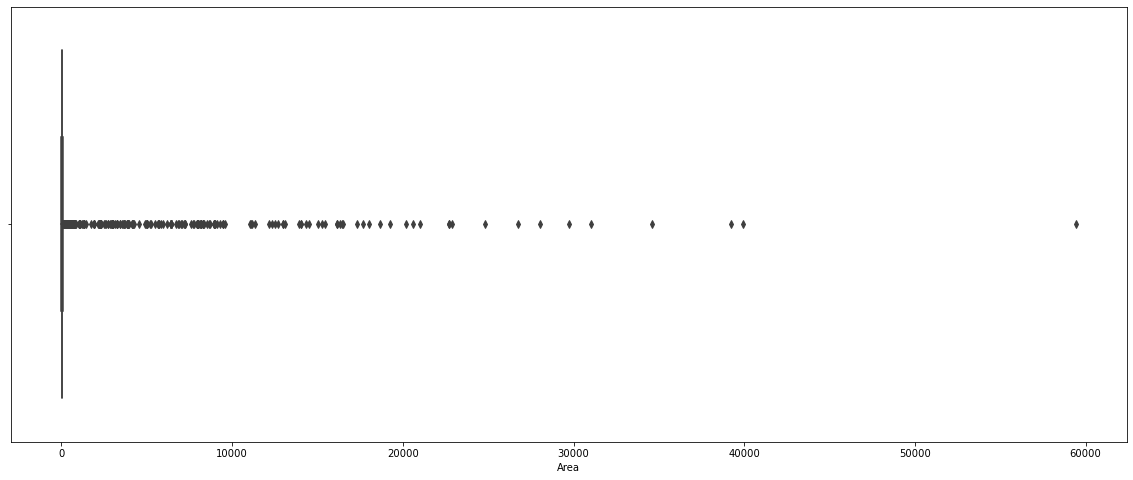

In [54]:
# Revisar la distribución y los valores atípicos
plt.figure(figsize=(20, 8))
#sns.boxplot(data=df, x="Area", y="Tipo_Area_PH")
sns.boxplot(x=df["Area"])
plt.show()

## Análisis

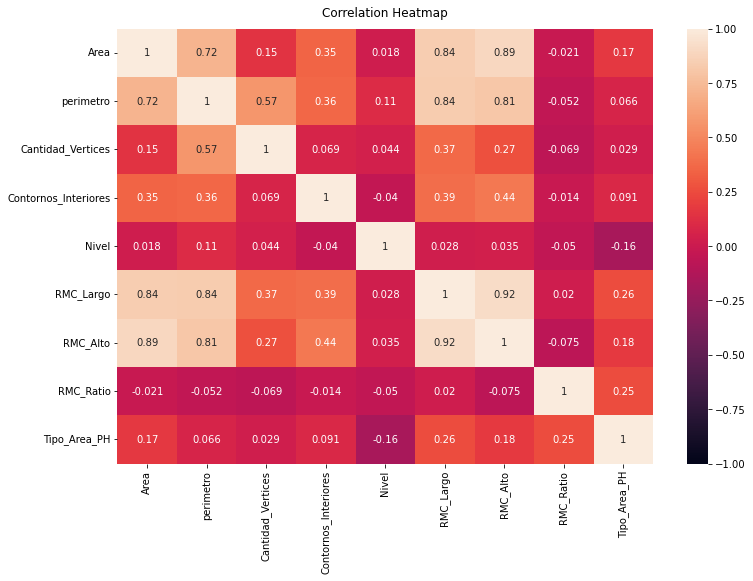

In [37]:
# Correlación
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

## Selección de Variables

## Creación de Modelo

## Creación de Pipeline

## Evaluación de Modelos

## Ajuste de Hiperparámetros

## Creación de Joblib